# 📦 프로젝트: E-Commerce 배송 지연의 '진짜 원인'을 찾아서
## 부제: 재고 처리(Stock Clearance) 이벤트 가설 검증

### 1. 분석 배경 및 가설 설정
데이터 탐색 결과, 배송 지연(`Reached.on.Time_Y.N = 1`)의 가장 강력한 원인으로 **'할인율(Discount_offered)'**이 지목되었습니다.
우리는 이것이 단순한 우연이 아니라, **"회사가 특정 기간에 대규모 재고 떨이(Stock Clearance) 이벤트를 진행했고, 이로 인해 물류가 마비되어 배송이 지연되었다"**는 가설을 세웠습니다.

### 2. 분석 목표
이 노트북은 다음 세 가지 단계로 위 가설을 증명합니다.
1.  **Trigger 확인:** 할인율이 몇 %를 넘을 때 지연이 폭발하는가? (임계점 발견)
2.  **고객 특성 확인:** 고할인(재고 처리) 상품을 산 고객은 누구인가? (특정 타겟층인가, 무작위인가?)
3.  **물류 특성 확인:** 그 상품들은 어떤 것이며, 어떻게 운송되었는가? (물류 비용 절감 흔적 찾기)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform

# (1) 그래프 스타일 설정 (폰트 설정보다 먼저 해야 함)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    sns.set_style("whitegrid")

# (2) 운영체제(OS)에 따른 폰트 자동 설정
system_name = platform.system()

if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic') # 윈도우
    print("✅ Windows 환경: 'Malgun Gothic' 폰트 설정 완료")
elif system_name == 'Darwin': 
    plt.rc('font', family='AppleGothic')   # 맥(Mac)
    print("✅ Mac 환경: 'AppleGothic' 폰트 설정 완료")
else:
    print("⚠️ Linux/Colab 환경: 별도 한글 폰트 설치가 필요합니다.")


plt.rcParams['axes.unicode_minus'] = False


# 데이터 로드 

file_path = r'C:\Users\User\github\sklearn-est-15th\firstProject\Ecom_Shipping-main\data\Train.csv'

try:
    df = pd.read_csv(file_path)
    print(f"✅ 데이터 로드 성공: {df.shape}")
except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. file_path를 확인해주세요.")

✅ Windows 환경: 'Malgun Gothic' 폰트 설정 완료
✅ 데이터 로드 성공: (10999, 12)


In [28]:
# ---------------------------------------------------------
#  데이터 구조 및 결측치 확인
# ---------------------------------------------------------
# (1) 데이터 크기(행, 열) 확인
print(f"📌 데이터 크기 (Shape): {df.shape}")
print("-" * 30)

# (2) 컬럼별 데이터 타입 및 결측치 요약 (Info)
print("📌 데이터 정보 (Info):")
df.info()
print("-" * 30)

# (3) 결측치 개수 확인 (Isnull Sum)
null_cnt = df.isnull().sum()
print(f"📌 결측치 총계 (Total Nulls): {null_cnt.sum()}")
if null_cnt.sum() > 0:
    print("\n[컬럼별 결측치]")
    print(null_cnt[null_cnt > 0])
else:
    print("✅ 결측치가 없습니다. (Clean Data)")

📌 데이터 크기 (Shape): (10999, 12)
------------------------------
📌 데이터 정보 (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
------------------------------
📌 결측치 총계 (Total Nulls): 0
✅ 결측치가 없습니다. (Clean 

## Step 1. 증거 확보: 할인율과 배송 지연의 '임계점' 찾기

**"단순히 할인을 받았다고 늦는 게 아니라, 특정 수준 이상의 '할인 행사'가 문제였을 것이다"**라는 가설을 검증합니다.
연속된 숫자로 되어 있는 할인율(`Discount_offered`)을 구간별로 나누어, **지연율이 급격히 치솟는 구간(Threshold)**을 찾아냅니다.

✅ 파생변수 생성 완료: 'Discount_Range'


C:\Users\User\AppData\Local\Temp\ipykernel_17748\573180031.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Discount_Range', data=df, ax=ax1, palette='Blues', alpha=0.5)


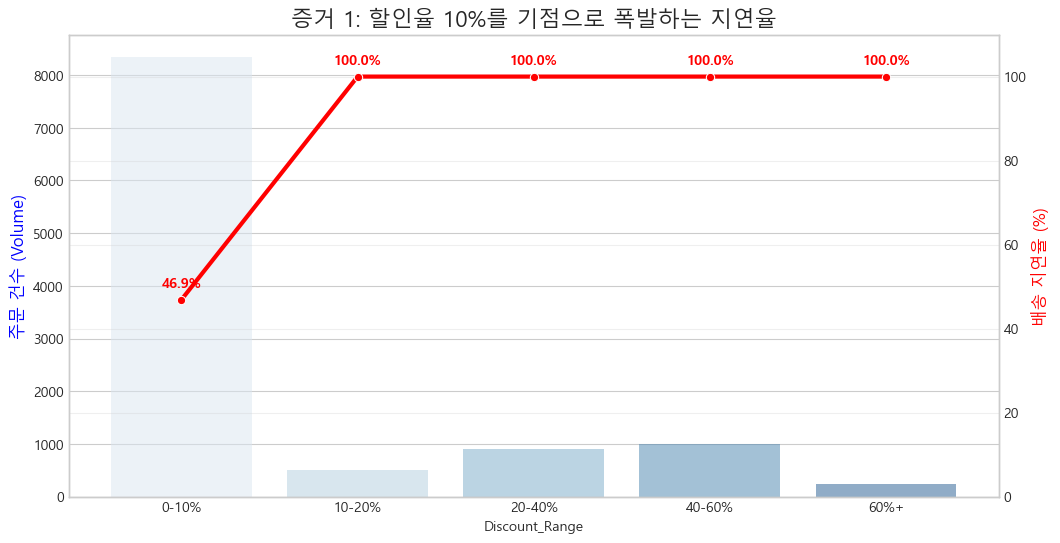

In [29]:
# [파생변수 생성 1] Discount_Range (할인율 구간)
# ❓ 생성 이유 (Why):
# 할인율(1~65%)은 연속된 수치라 패턴이 한눈에 들어오지 않습니다.
# 이를 10% 단위로 구간화(Binning)하면 "지연율이 폭발하는 특정 구간"을 명확히 시각화할 수 있습니다.

# 1. 구간 설정 (0~10%, 10~20% ... )
bins = [0, 10, 20, 40, 60, 100]
labels = ['0-10%', '10-20%', '20-40%', '40-60%', '60%+']
df['Discount_Range'] = pd.cut(df['Discount_offered'], bins=bins, labels=labels)

print("✅ 파생변수 생성 완료: 'Discount_Range'")

# 2. 시각화: 물량(Volume)과 지연율(Delay Rate) 동시 확인
fig, ax1 = plt.subplots(figsize=(12, 6))

# [막대 그래프] 구간별 물량 분포 (Blue)
sns.countplot(x='Discount_Range', data=df, ax=ax1, palette='Blues', alpha=0.5)
ax1.set_ylabel('주문 건수 (Volume)', color='blue', fontsize=12)
ax1.set_title('증거 1: 할인율 10%를 기점으로 폭발하는 지연율', fontsize=16)

# [선 그래프] 구간별 배송 지연율 (Red)
ax2 = ax1.twinx()
delay_trend = df.groupby('Discount_Range', observed=True)['Reached.on.Time_Y.N'].mean() * 100
sns.lineplot(x=delay_trend.index, y=delay_trend.values, ax=ax2, color='red', marker='o', linewidth=3)

ax2.set_ylabel('배송 지연율 (%)', color='red', fontsize=12)
ax2.set_ylim(0, 110) # 0~100% 표현

# 지연율 수치 텍스트 표시
for i, val in enumerate(delay_trend.values):
    ax2.text(i, val + 3, f'{val:.1f}%', color='red', ha='center', fontweight='bold')

plt.grid(True, axis='y', alpha=0.3)
plt.show()

## Step 2. 그룹 비교: '할인 행사(Event)' 대상 고객 분석

앞선 분석에서 할인율 **10%**가 지연의 결정적 기준임이 확인되었습니다.
이제 10%를 기준으로 데이터를 **`할인행사(Event)`** 그룹과 **`일반(Normal)`** 그룹으로 나누어 비교합니다.

이 '할인 행사' 그룹이 특정 충성 고객(VIP)을 위한 것인지, 아니면 무작위 대중을 대상으로 한 재고 처리 이벤트였는지 파악해 봅니다.

✅ 파생변수 생성 완료: 'Discount_Event'
Discount_Event
Normal (일반)              8352
Discount Event (할인행사)    2647
Name: count, dtype: int64


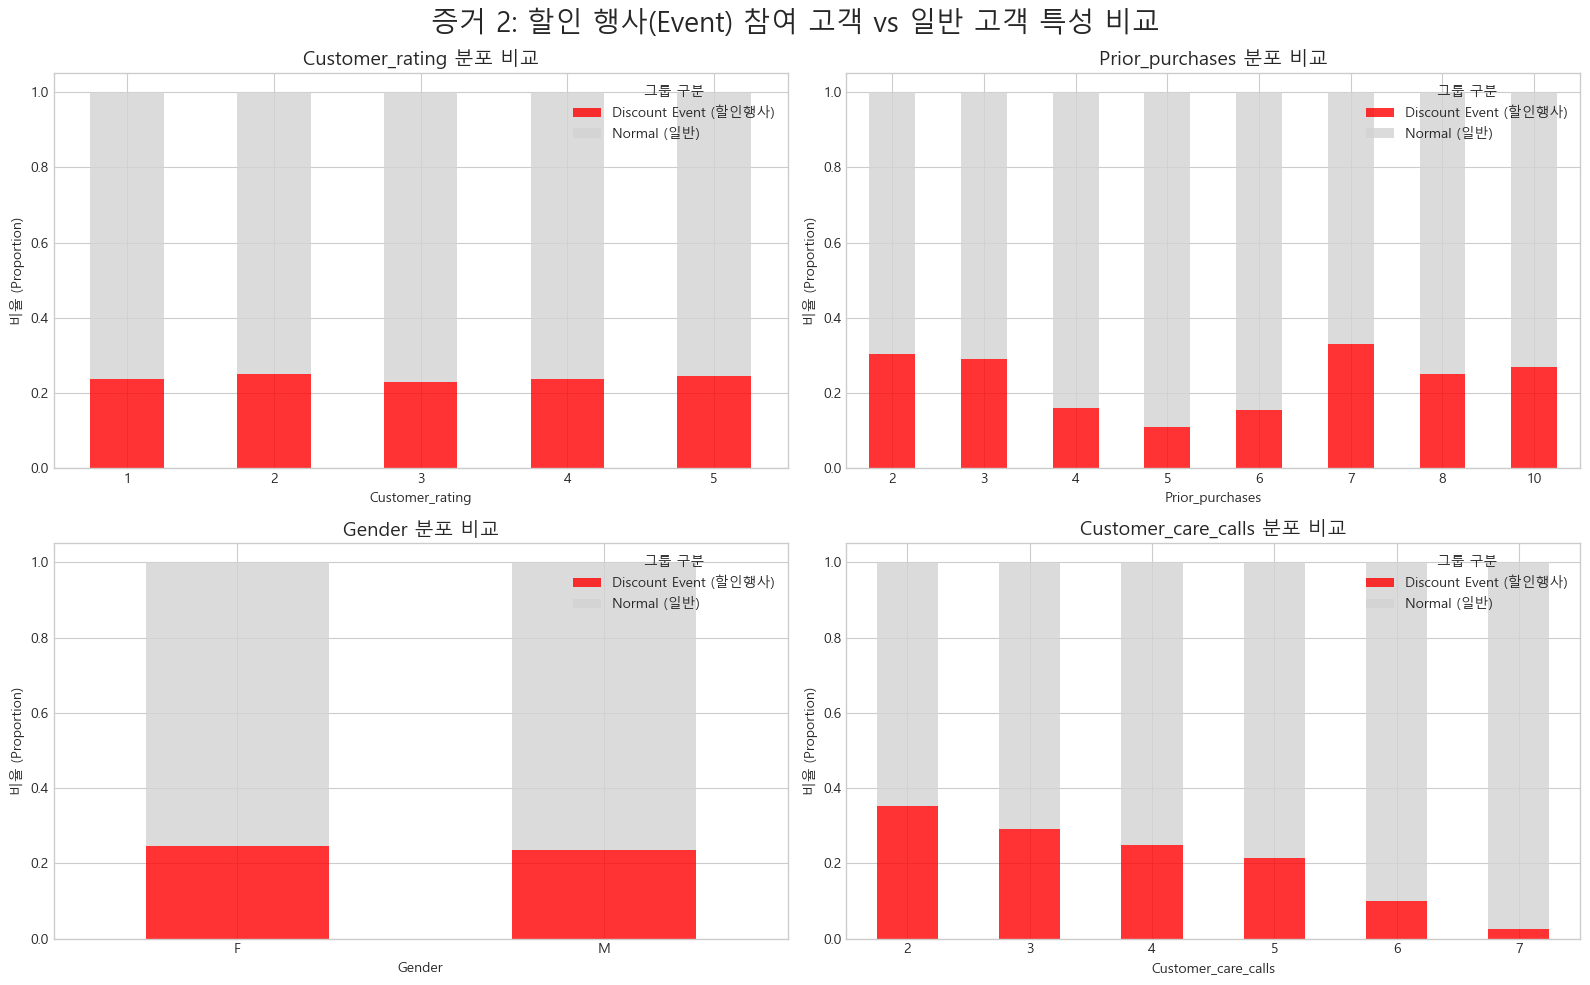

In [30]:

# [파생변수 생성 2] Discount_Event (할인 행사 여부)
# ❓ 생성 이유 (Why):
# 앞서 발견한 임계점(10%)을 기준으로 데이터를 두 그룹으로 명확히 분류하기 위함입니다.
# - 'Discount Event (할인행사)': 10% 초과 (지연 위험군)
# - 'Normal (일반)': 10% 이하 (안전군)
# 이를 통해 "할인 행사가 누구를 타겟으로 했는가?"를 분석할 수 있습니다.


# 1. 그룹핑 (Grouping)
df['Discount_Event'] = df['Discount_offered'].apply(lambda x: 'Discount Event (할인행사)' if x > 10 else 'Normal (일반)')

print("✅ 파생변수 생성 완료: 'Discount_Event'")
print(df['Discount_Event'].value_counts()) # 그룹별 개수 확인

# 2. 다각도 비교 분석 (고객 등급, 이전 구매 횟수, 성별, 문의 전화)
# -> 할인 행사에 참여한 사람들의 특성을 파악
compare_cols = ['Customer_rating', 'Prior_purchases', 'Gender', 'Customer_care_calls']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle('증거 2: 할인 행사(Event) 참여 고객 vs 일반 고객 특성 비교', fontsize=20)

for i, col in enumerate(compare_cols):
    row, col_idx = i // 2, i % 2
    
    # normalize='index'를 사용하여 '비율(%)'로 비교 (데이터 개수 차이 보정)
    cross_tab = pd.crosstab(df[col], df['Discount_Event'], normalize='index')
    
    # 누적 막대 그래프
    cross_tab.plot(kind='bar', stacked=True, ax=axes[row, col_idx], 
                   color=['red', 'lightgray'], alpha=0.8) # red: 할인행사, gray: 일반
    
    axes[row, col_idx].set_title(f'{col} 분포 비교', fontsize=14)
    axes[row, col_idx].set_ylabel('비율 (Proportion)')
    axes[row, col_idx].legend(title='그룹 구분', loc='upper right')
    axes[row, col_idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 🛑 [중간 점검] 그래서, 두 그룹의 운명은 얼마나 달랐나?

고객 특성은 비슷해 보였지만, 실제 **배송 지연율(Delay Rate)**을 비교해보면 충격적인 차이가 드러납니다.
이 그래프는 우리가 나눈 `Discount Event` 그룹이 지연을 예측하는 데 얼마나 강력한 변수인지 증명합니다.

📊 [충격적인 결과 비교]
- 일반 고객(Normal) 지연율: 46.9%
- 행사 고객(Event) 지연율 : 100.0%
--------------------------------------------------
📢 결론: '할인 행사' 그룹에 속하는 순간, 배송 지연은 사실상 피할 수 없는 확정적 미래가 됩니다.


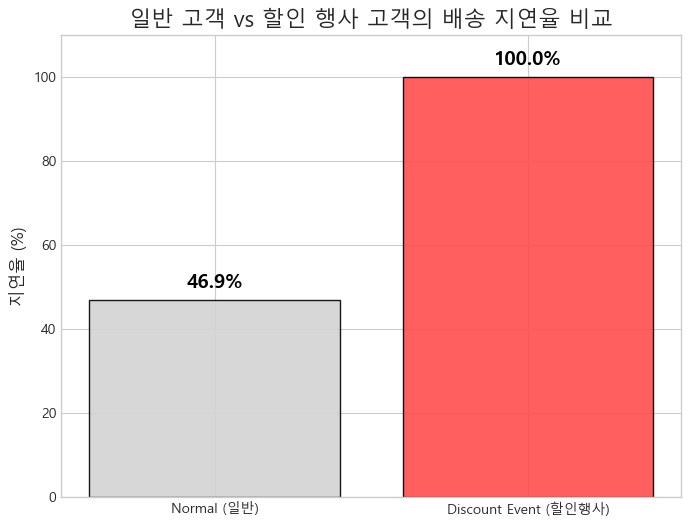

In [33]:
# ---------------------------------------------------------
# [핵심 비교] 일반 vs 할인행사 그룹의 배송 지연율 차이
# ---------------------------------------------------------

# 1. 그룹별 지연율 계산
# mean()은 0과 1의 평균이므로, 여기에 100을 곱하면 지연율(%)이 됩니다.
delay_comparison = df.groupby('Discount_Event')['Reached.on.Time_Y.N'].mean() * 100
delay_comparison = delay_comparison.reindex(['Normal (일반)', 'Discount Event (할인행사)']) # 순서 정렬

# 2. 막대 그래프 시각화
plt.figure(figsize=(8, 6))
bars = plt.bar(delay_comparison.index, delay_comparison.values, 
               color=['lightgray', '#ff4d4d'], edgecolor='black', alpha=0.9)

plt.title('일반 고객 vs 할인 행사 고객의 배송 지연율 비교', fontsize=16)
plt.ylabel('지연율 (%)', fontsize=12)
plt.ylim(0, 110) # y축 여유 있게

# 3. 수치 표시 (Highlight)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2, f'{height:.1f}%', 
             ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

# 4. 결론 출력
print(f"📊 [충격적인 결과 비교]")
print(f"- 일반 고객(Normal) 지연율: {delay_comparison['Normal (일반)']:.1f}%")
print(f"- 행사 고객(Event) 지연율 : {delay_comparison['Discount Event (할인행사)']:.1f}%")
print("-" * 50)
print("📢 결론: '할인 행사' 그룹에 속하는 순간, 배송 지연은 사실상 피할 수 없는 확정적 미래가 됩니다.")

### 🧐 [심층 분석] 배송이 100% 늦었는데, 고객 만족도(Rating)는 어떨까?

우리는 앞서 **'할인 행사(Event)'** 그룹의 배송이 거의 100% 지연되었다는 사실을 확인했습니다.
그렇다면, **"배송이 늦었으니 고객들이 화가 나서 별점(Rating)을 낮게 줬을까요?"**

이 코드는 **일반 고객**과 **할인 행사 고객(지연된 고객)**의 평균 별점과 분포를 비교하여, 배송 지연이 실제 고객 만족도에 타격을 줬는지 검증합니다.

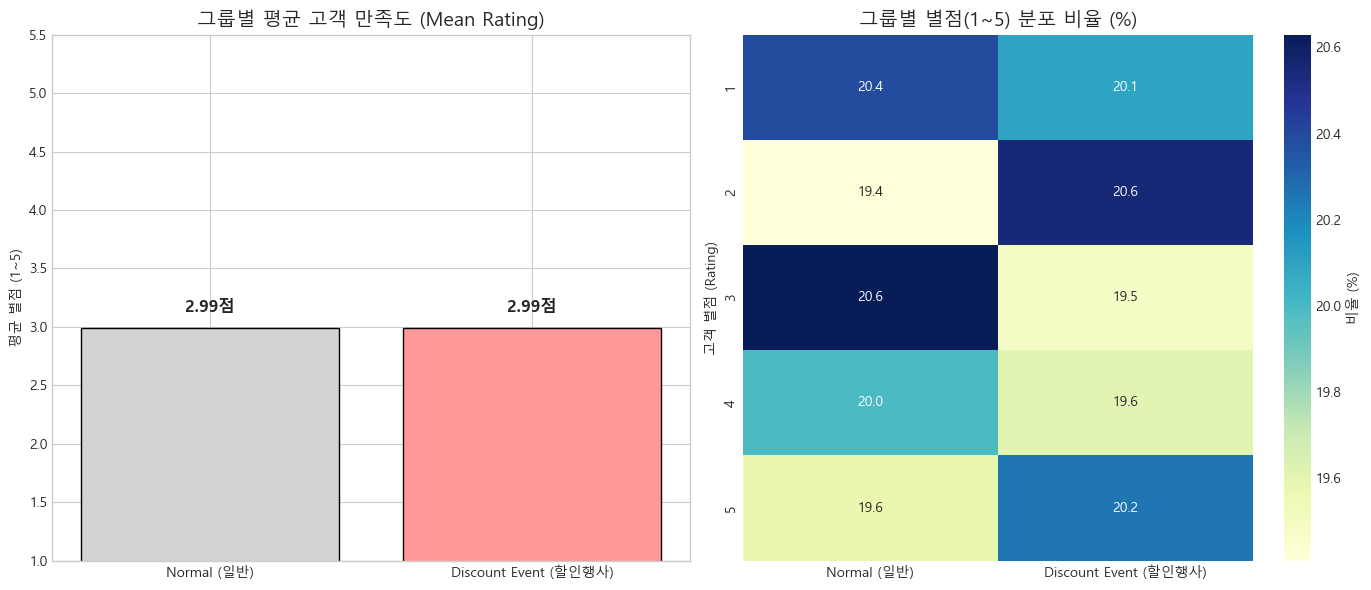

📊 [분석 결과]
- 일반 고객 평균 별점: 2.99점
- 행사 고객 평균 별점: 2.99점
- 점수 차이: 0.00점

📢 충격적인 결론: 배송이 100% 늦었음에도 불구하고, 고객 만족도에는 차이가 없습니다!
   -> 이유 추론: 고객들은 '싼 가격'에 만족하여 배송 지연을 너그럽게 이해했거나,
                 별점 시스템 자체가 배송 품질보다는 '상품 품질'에 대한 평가일 수 있습니다.


In [34]:
# ---------------------------------------------------------
# [팩트 체크] 할인 행사(지연) 여부와 고객 만족도(Rating)의 관계
# ---------------------------------------------------------

# 1. 그룹별 평균 별점(Rating) 계산
rating_mean = df.groupby('Discount_Event')['Customer_rating'].mean()
rating_mean = rating_mean.reindex(['Normal (일반)', 'Discount Event (할인행사)'])

# 2. 별점 분포 시각화 (1점~5점 비율 비교)
# 각 그룹 내에서 1~5점의 비율이 어떻게 되는지 확인
rating_dist = pd.crosstab(df['Customer_rating'], df['Discount_Event'], normalize='columns') * 100
rating_dist = rating_dist[['Normal (일반)', 'Discount Event (할인행사)']]

# 시각화 (2분할)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# [왼쪽] 평균 별점 비교 (Bar Plot)
colors = ['lightgray', '#ff9999']
bars = ax[0].bar(rating_mean.index, rating_mean.values, color=colors, edgecolor='black')
ax[0].set_title('그룹별 평균 고객 만족도 (Mean Rating)', fontsize=14)
ax[0].set_ylim(1, 5.5) # 별점은 1~5점이므로
ax[0].set_ylabel('평균 별점 (1~5)')

# 수치 표시
for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2.0, height + 0.1, f'{height:.2f}점', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')

# [오른쪽] 별점 분포 상세 비교 (Heatmap)
sns.heatmap(rating_dist, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax[1], cbar_kws={'label': '비율 (%)'})
ax[1].set_title('그룹별 별점(1~5) 분포 비율 (%)', fontsize=14)
ax[1].set_ylabel('고객 별점 (Rating)')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# [결론 도출]
# ---------------------------------------------------------
print("📊 [분석 결과]")
diff = abs(rating_mean['Normal (일반)'] - rating_mean['Discount Event (할인행사)'])
print(f"- 일반 고객 평균 별점: {rating_mean['Normal (일반)']:.2f}점")
print(f"- 행사 고객 평균 별점: {rating_mean['Discount Event (할인행사)']:.2f}점")
print(f"- 점수 차이: {diff:.2f}점")

if diff < 0.1:
    print("\n📢 충격적인 결론: 배송이 100% 늦었음에도 불구하고, 고객 만족도에는 차이가 없습니다!")
    print("   -> 이유 추론: 고객들은 '싼 가격'에 만족하여 배송 지연을 너그럽게 이해했거나,")
    print("                 별점 시스템 자체가 배송 품질보다는 '상품 품질'에 대한 평가일 수 있습니다.")
else:
    print("\n📢 결론: 예상대로 배송 지연이 고객 만족도 하락에 영향을 주었습니다.")

## Step 3. 물류 추적: '할인 행사' 상품들의 운송 비밀

마지막으로, 지연의 주범인 **`Discount Event (할인행사)`** 상품들만 따로 떼어내어 물류 프로세스를 역추적합니다.

대규모 할인 행사를 진행하면서 **물류 비용을 아끼기 위해** 어떤 선택을 했는지(저가 운송 수단, 특정 창고 등)를 데이터로 증명합니다.

C:\Users\User\AppData\Local\Temp\ipykernel_17748\2573477744.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Product_importance', data=event_df, ax=ax[0],
C:\Users\User\AppData\Local\Temp\ipykernel_17748\2573477744.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Mode_of_Shipment', data=event_df, ax=ax[1], palette='Purples')
C:\Users\User\AppData\Local\Temp\ipykernel_17748\2573477744.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Warehouse_block', data=event_df, ax=ax[2], palette='Greens')


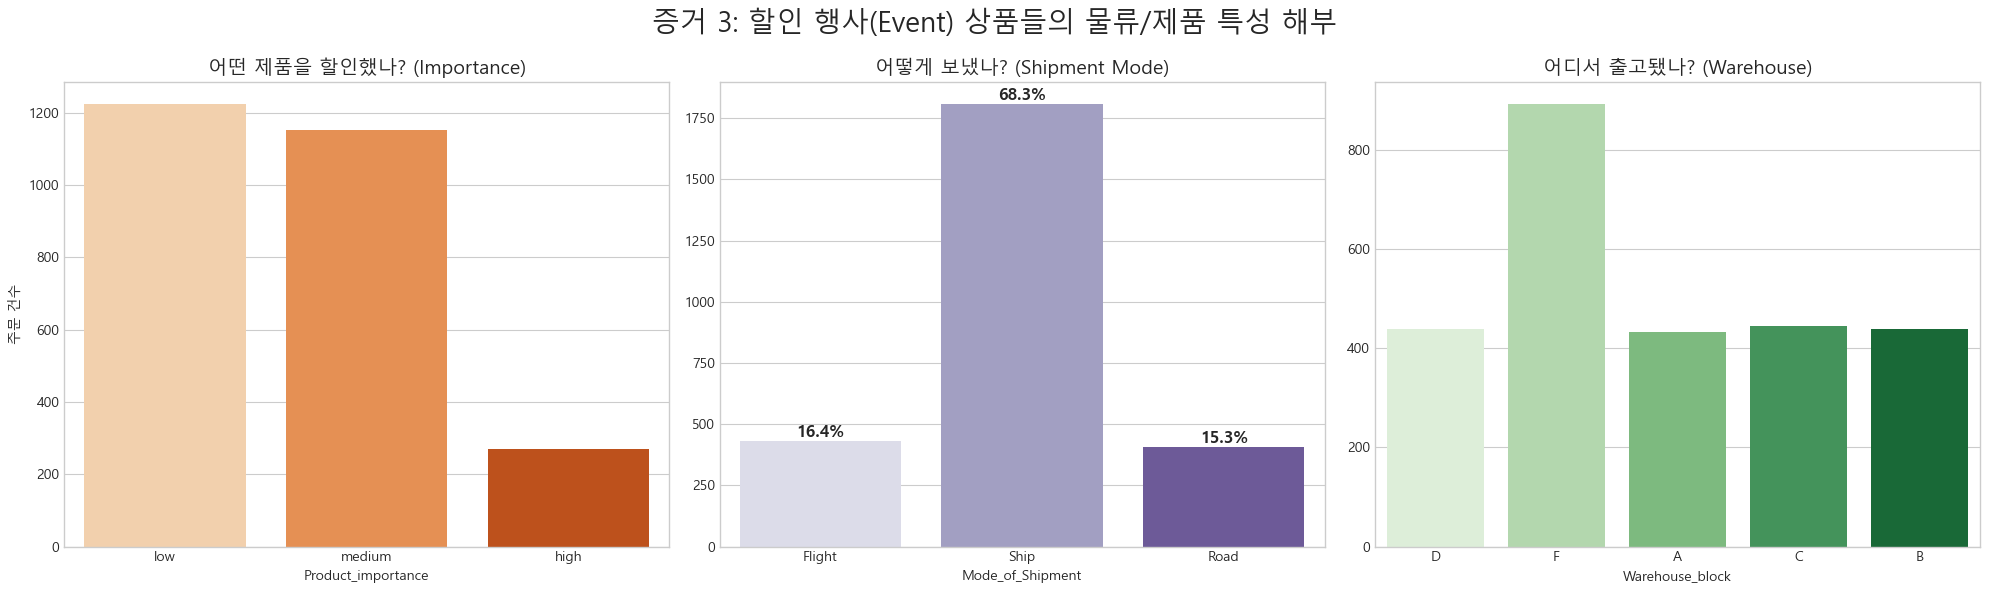

🏁 [분석 결과] 할인 행사 상품의 선박(Ship) 이용 비율: 68.3%
📢 결론: 회사는 대규모 할인 행사 물량을 처리하며 비용 절감을 위해 '선박(Ship)'을 집중적으로 사용했습니다.
   -> 이것이 할인 행사 상품들의 100% 가까운 지연율을 만든 물리적 원인입니다.


In [31]:
# ---------------------------------------------------------
# [심층 분석] 'Discount Event (할인행사)' 그룹만 필터링
# ---------------------------------------------------------
# ❓ 분석 이유 (Why):
# 전체 데이터가 섞여 있으면 "할인 행사 상품"만의 특징이 희석됩니다.
# 문제의 핵심인 '할인행사' 데이터만 따로 추출하여,
# 이들이 어떤 운송 수단(Ship/Flight)과 창고(Warehouse)를 이용했는지 집중 조명합니다.
# ---------------------------------------------------------

# 1. 할인 행사 데이터만 추출
event_df = df[df['Discount_Event'] == 'Discount Event (할인행사)']

# 2. 물류 특성 시각화 (제품 중요도, 운송 수단, 창고)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle('증거 3: 할인 행사(Event) 상품들의 물류/제품 특성 해부', fontsize=20)

# [1] 제품 중요도 (Product Importance)
sns.countplot(x='Product_importance', data=event_df, ax=ax[0], 
              order=['low', 'medium', 'high'], palette='Oranges')
ax[0].set_title('어떤 제품을 할인했나? (Importance)', fontsize=14)
ax[0].set_ylabel('주문 건수')

# [2] 운송 수단 (Mode of Shipment) -> 핵심 포인트!
sns.countplot(x='Mode_of_Shipment', data=event_df, ax=ax[1], palette='Purples')
ax[1].set_title('어떻게 보냈나? (Shipment Mode)', fontsize=14)
ax[1].set_ylabel('')

# 비율(%) 표시 (Ship 비율 확인용)
total_event = len(event_df)
for p in ax[1].patches:
    percentage = f'{100 * p.get_height() / total_event:.1f}%'
    ax[1].annotate(percentage, (p.get_x() + 0.4, p.get_height()), 
                   ha='center', va='bottom', fontweight='bold', fontsize=12)

# [3] 출고 창고 (Warehouse Block)
sns.countplot(x='Warehouse_block', data=event_df, ax=ax[2], palette='Greens')
ax[2].set_title('어디서 출고됐나? (Warehouse)', fontsize=14)
ax[2].set_ylabel('')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# [결론 도출]
# ---------------------------------------------------------
ship_ratio = event_df[event_df['Mode_of_Shipment'] == 'Ship'].shape[0] / total_event * 100
print(f"🏁 [분석 결과] 할인 행사 상품의 선박(Ship) 이용 비율: {ship_ratio:.1f}%")

if ship_ratio > 60:
    print("📢 결론: 회사는 대규모 할인 행사 물량을 처리하며 비용 절감을 위해 '선박(Ship)'을 집중적으로 사용했습니다.")
    print("   -> 이것이 할인 행사 상품들의 100% 가까운 지연율을 만든 물리적 원인입니다.")

<Figure size 1000x600 with 0 Axes>

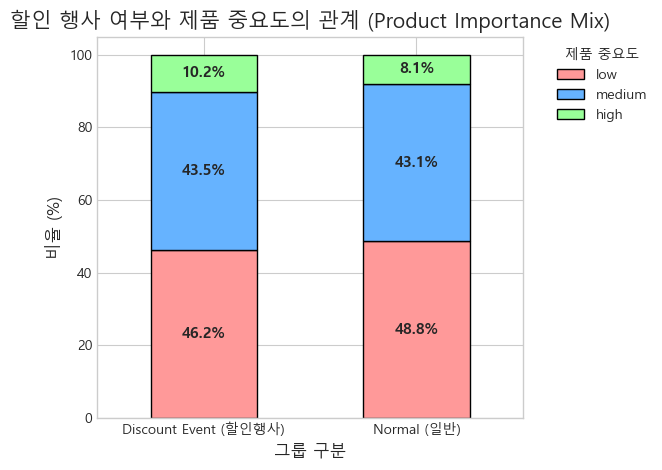

📊 [분석 해석]
1. 할인 행사 상품 중 'Low(저중요도)' 비율: 46.2%
2. 일반 상품 중 'Low(저중요도)' 비율: 48.8%


In [32]:

# [시각화] 할인 행사(Event) 여부에 따른 제품 중요도 분포 비교
# ---------------------------------------------------------

# 1. 파생변수 생성 (아직 안 만들었다면 실행)
df['Discount_Event'] = df['Discount_offered'].apply(lambda x: 'Discount Event (할인행사)' if x > 10 else 'Normal (일반)')

# 2. 교차표 생성 (비율로 변환하여 비교)
# normalize='index' : 각 그룹(행)의 합이 100%가 되도록 계산
cross_tab = pd.crosstab(df['Discount_Event'], df['Product_importance'], normalize='index') * 100

# 순서 정렬 (Low -> Medium -> High)
cross_tab = cross_tab[['low', 'medium', 'high']]

# 3. 100% 누적 막대 그래프 시각화
plt.figure(figsize=(10, 6))
ax = cross_tab.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff', '#99ff99'], edgecolor='black', rot=0)

plt.title('할인 행사 여부와 제품 중요도의 관계 (Product Importance Mix)', fontsize=15)
plt.ylabel('비율 (%)', fontsize=12)
plt.xlabel('그룹 구분', fontsize=12)
plt.legend(title='제품 중요도', bbox_to_anchor=(1.05, 1), loc='upper left')

# 막대 안에 % 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 5: # 5% 이상인 경우만 표시 (글자 겹침 방지)
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', 
                ha='center', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# [해석 가이드]
# ---------------------------------------------------------
print("📊 [분석 해석]")
event_low_ratio = cross_tab.loc['Discount Event (할인행사)', 'low']
normal_low_ratio = cross_tab.loc['Normal (일반)', 'low']

print(f"1. 할인 행사 상품 중 'Low(저중요도)' 비율: {event_low_ratio:.1f}%")
print(f"2. 일반 상품 중 'Low(저중요도)' 비율: {normal_low_ratio:.1f}%")

if event_low_ratio > normal_low_ratio:
    print("\n✅ 결론: 할인 행사(이벤트)는 주로 '중요도가 낮은(Low)' 재고 상품들을 대상으로 진행되었습니다.")
    print("   -> 중요도가 낮기 때문에 기업 입장에서는 재고 처리를 위해 대폭 할인을 감행했을 가능성이 높습니다.")